In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Wind.Results import DBResults
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
from Wind.Private.DBConfig import mongolocaltest, mongolocal
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Fitting RNN Encoder Decoder

## Fit1

First fit experiment RNN seq2seq, explore dropout and number of input and output neurons

In [3]:

query={'experiment':'rnnfit'}

results = DBResults(conn=mongolocaltest)
#results = DBResults()

results.retrieve_results_dataframe(query, arch=['drop', 'neuronsE', 'neuronsD'])

Samples 5% and plots a distribution plot of the sum of the R² of all the hours

In [4]:
a=results.exp_df.groupby(['site', 'drop', 'neuronsE', 'neuronsD'],as_index=False).sum()
a.drop(columns=['hour', 'site'], inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa01bb02630>,
      dtype=object)

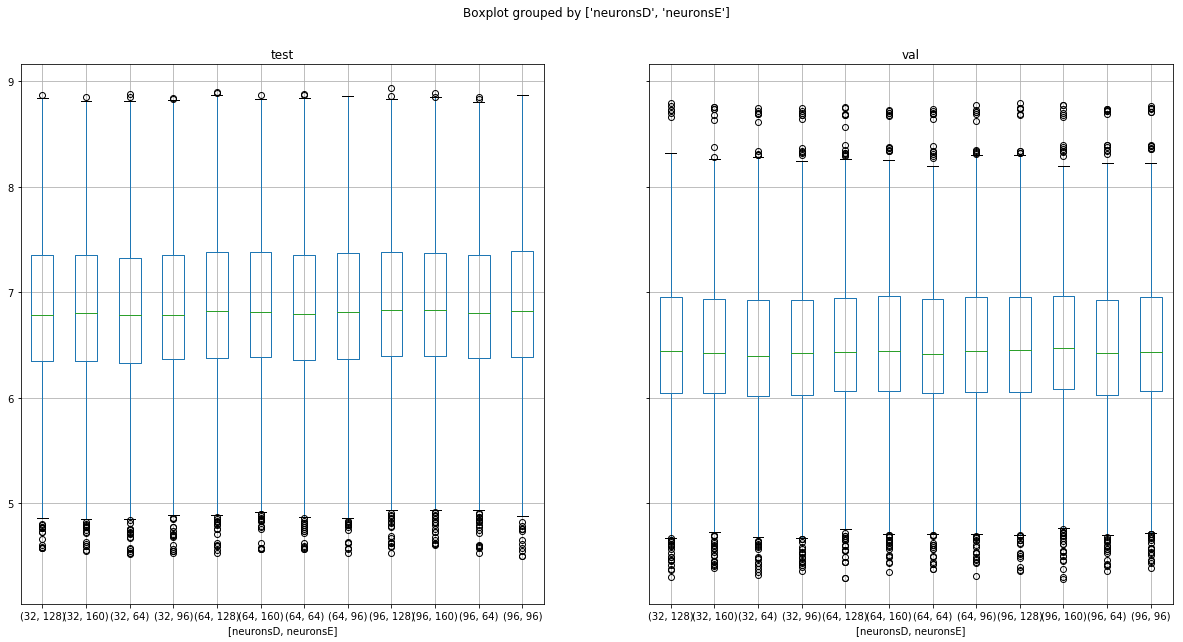

In [5]:
# plt.figure(figsize=(12,8), dpi=100)
# plt.style.use('seaborn-whitegrid')
# plt.xticks(rotation=90)
#sns.boxplot(x='neuronsD', by='dropout', y='test', data=a)
a.boxplot(by=['neuronsD', 'neuronsE'],figsize=(20,10))

Selects the 500 best/worst results and plots in a map the sum of R² of all the hours for test and validation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa02381c6d8>,
      dtype=object)

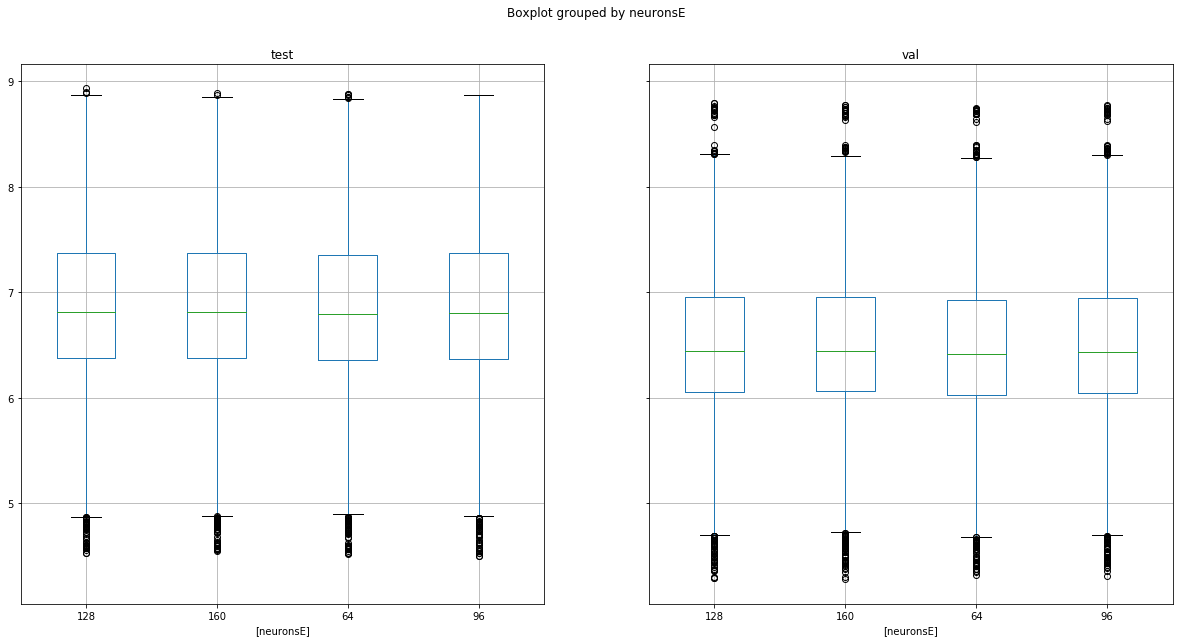

In [6]:
a.boxplot(by='neuronsE',figsize=(20,10))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa021bee9e8>,
      dtype=object)

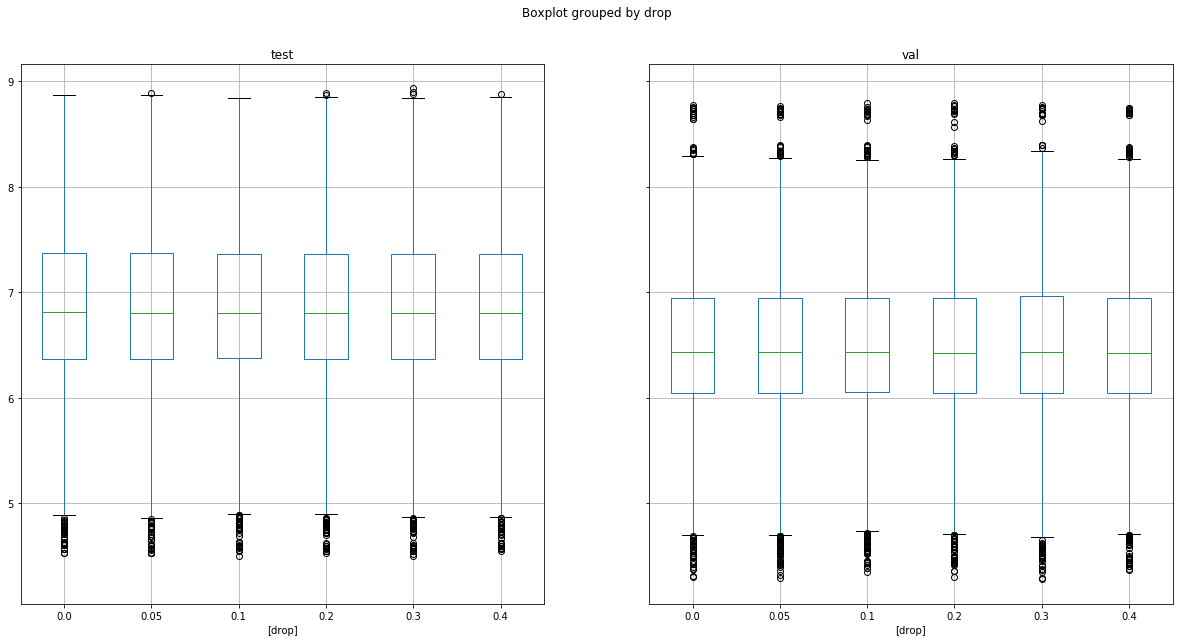

In [7]:
a.boxplot(by='drop',figsize=(20,10))

In [8]:
b =a.groupby(by=['neuronsD', 'neuronsE', 'drop'],as_index=False).mean()
b[b.neuronsD=='96'].style.highlight_max()

,neuronsD,neuronsE,drop,test,val
48,96,128,0.0,6.81183,6.49482
49,96,128,0.05,6.80763,6.50022
50,96,128,0.1,6.80649,6.49258
51,96,128,0.2,6.80444,6.48456
52,96,128,0.3,6.80867,6.49034
53,96,128,0.4,6.8092,6.49131
54,96,160,0.0,6.81646,6.49306
55,96,160,0.05,6.80852,6.50072
56,96,160,0.1,6.80771,6.50314
57,96,160,0.2,6.81359,6.49162


Best results  96/160/0.0

Second fit of RNN, explore type of unit, lag and some more neuronsE and neuronsD

## Fit2

In [9]:
query={'experiment':'rnnfit2'}

results = DBResults(conn=mongolocaltest)
#results = DBResults()

results.retrieve_results_dataframe(query, arch=['drop', 'neuronsE', 'neuronsD', 'rnn'], data=['lag'])

In [10]:
a=results.exp_df.groupby(['site', 'drop', 'neuronsE', 'neuronsD', 'lag','rnn'],as_index=False).sum()
a.drop(columns=['hour', 'site'], inplace=True)

In [11]:
b =a.groupby(by=['neuronsD', 'neuronsE', 'drop', 'lag','rnn'],as_index=False).mean()

In [12]:
b.describe(include='all')

,neuronsD,neuronsE,drop,lag,rnn,test,val
count,192,192,192,192,192,192.000000,192.000000
unique,3,4,2,4,2,NaN,NaN
top,128,128,0.0,24,LSTM,NaN,NaN
freq,64,48,96,48,96,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.715054,6.401622
std,NaN,NaN,NaN,NaN,NaN,0.066117,0.062510
min,NaN,NaN,NaN,NaN,NaN,6.591258,6.277024
25%,NaN,NaN,NaN,NaN,NaN,6.664541,6.353330
50%,NaN,NaN,NaN,NaN,NaN,6.712954,6.399413
75%,NaN,NaN,NaN,NaN,NaN,6.772341,6.449905


In [13]:
b[b.neuronsD=='128'].style.highlight_max()

,neuronsD,neuronsE,drop,lag,rnn,test,val
0,128,128,0.0,12,GRU,6.81623,6.49497
1,128,128,0.0,12,LSTM,6.73749,6.42588
2,128,128,0.0,18,GRU,6.81431,6.49696
3,128,128,0.0,18,LSTM,6.707,6.39219
4,128,128,0.0,24,GRU,6.80364,6.48031
5,128,128,0.0,24,LSTM,6.68136,6.35348
6,128,128,0.0,6,GRU,6.7892,6.46975
7,128,128,0.0,6,LSTM,6.74863,6.42755
8,128,128,0.1,12,GRU,6.64353,6.32863
9,128,128,0.1,12,LSTM,6.73287,6.41983


Best results 196/128/0.0/12/GRU

## Fit3

Third fit of RNN, explore number of layers

In [14]:
query={'experiment':'rnnfit3'}

results = DBResults(conn=mongolocaltest)
#results = DBResults()

results.retrieve_results_dataframe(query, arch=['neuronsE', 'neuronsD', 'nlayersE', 'nlayersD'])

In [15]:
a=results.exp_df.groupby(['site',  'neuronsE', 'neuronsD', 'nlayersE', 'nlayersD'],as_index=False).sum()
a.drop(columns=['hour', 'site'], inplace=True)


In [16]:
b =a.groupby(by=['neuronsD', 'neuronsE', 'nlayersE', 'nlayersD' ],as_index=False).mean()
b.style.highlight_max()

,neuronsD,neuronsE,nlayersE,nlayersD,test,val
0,128,196,1,1,6.84386,6.52547
1,128,196,1,2,6.84847,6.52664
2,128,196,1,3,6.84561,6.52458
3,128,196,2,1,6.81093,6.49777
4,128,196,2,2,6.81868,6.51313
5,128,196,2,3,6.82869,6.50099
6,128,196,3,1,6.80223,6.49487
7,128,196,3,2,6.81513,6.49991
8,128,196,3,3,6.81094,6.50263
9,196,196,1,1,6.84723,6.5197


Best results 196(1)/128(2)/0.0/GRU/lag=12

## Fit 4

Fourth fit of RNN, reexplore lag, decoder neurons, dropout and decoder layers

In [17]:
query={'experiment':'rnnfit4'}

results = DBResults(conn=mongolocaltest)
#results = DBResults()

results.retrieve_results_dataframe(query, arch=['neuronsD', 'nlayersD', 'drop'], data=['lag'])

In [18]:
a=results.exp_df.groupby(['site', 'drop', 'neuronsD', 'lag','nlayersD'],as_index=False).sum()
a.drop(columns=['hour', 'site'], inplace=True)

In [19]:
b =a.groupby(by=['neuronsD',  'nlayersD', 'drop', 'lag' ],as_index=False).mean()
b.style.highlight_max()

,neuronsD,nlayersD,drop,lag,test,val
0,128,1,0.0,12,6.84472,6.525
1,128,1,0.0,18,6.83825,6.52107
2,128,1,0.0,24,6.8334,6.51835
3,128,1,0.05,12,6.84805,6.52397
4,128,1,0.05,18,6.83654,6.52348
5,128,1,0.05,24,6.83523,6.51435
6,128,1,0.1,12,6.84627,6.52443
7,128,1,0.1,18,6.84041,6.52512
8,128,1,0.1,24,6.83025,6.50594
9,128,2,0.0,12,6.84267,6.52217


final best configuration GRU/196/1/196/1/0.0/18

## Fit 5

Fifth fit of RNN, reexplore lag, decoder neurons, dropout and decoder layers

In [35]:
query={'experiment':'rnnedfit5'}

results = DBResults(conn=mongolocaltest)
#results = DBResults()

results.retrieve_results_dataframe(query, arch=['neuronsD', 'nlayersD', 'drop', 'full', 'fulldrop','activation_full'], data=['lag'])

In [36]:
a=results.exp_df.groupby(['site', 'drop', 'neuronsD', 'lag','nlayersD', 'full', 'fulldrop','activation_full'],as_index=False).sum()
a.drop(columns=['hour', 'site'], inplace=True)
len(a)

1835

In [37]:

b =a.groupby(by=['neuronsD',  'nlayersD', 'drop', 'lag', 'full', 'fulldrop','activation_full'],as_index=False).agg({'test':['mean','count','std'], 'val':'mean', })
b.style.highlight_max()


In [38]:
trace = []
facet = 'activation_full'
for v in sorted(b[facet].unique()):
    trace.append(go.Scatter(
        x = b[b[facet]==v]['test']['mean'],
        y = b[b[facet]==v]['val']['mean'],
        text='F-'+b[b[facet]==v]['full'].astype(str) + 'D-' + b[b[facet]==v]['fulldrop'].astype(str) + '-L' + b[b[facet]==v]['lag'].astype(str)+ '-F' + b[b[facet]==v]['lag'].astype(str), 
        mode = 'markers', name=v,
        marker={'size':b[b[facet]==v]['test']['std']*15}
    ))
py.iplot(trace, filename='basic-scatter')

final best configuration 